# Table of Contents

1. [Importing Necessary Dependencies](#importing-necessary-dependencies)
2. [Loading the Datasets](#loading-the-datasets)
3. [Defining Helper Functions](#defining-helper-functions)
4. [Data Preprocessing](#data-preprocessing)
5. [Model Training](#model-training)
6. [Model Evaluation](#model-evaluation)

# Importing Necessary Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.utils import class_weight
from xgboost import XGBClassifier

# Loading the Datasets

In [2]:
X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

In [3]:
X_train.drop(columns="code_snippet", inplace=True)
X_test.drop(columns="code_snippet", inplace=True)

In [4]:
X_train.head()

,loc,num_args,num_returns,num_variables,num_function_calls,has_decorators,uses_globals,is_recursive,estimated_difficulty,estimated_bugs,has_docstring,docstring_length,num_comments,name_length,is_name_well_formed,bad_variable_names_count,max_return_length,estimated_complexity
0,2,1,1,0,1,True,False,False,0.0,0.0,False,0,0,12,True,0,58,1
1,2,1,1,0,1,False,False,False,0.0,0.0,False,0,0,4,True,0,10,1
2,12,2,0,5,10,False,False,False,0.0,0.0,False,0,1,32,True,2,0,2
3,26,1,0,7,12,False,False,False,0.0,0.0,False,0,4,19,True,0,0,1
4,3,3,0,0,2,False,False,False,0.0,0.0,False,0,0,21,True,0,0,1


In [5]:
X_train.describe()

,loc,num_args,num_returns,num_variables,num_function_calls,estimated_difficulty,estimated_bugs,docstring_length,num_comments,name_length,bad_variable_names_count,max_return_length,estimated_complexity
count,84248.000000,84248.000000,84248.000000,84248.000000,84248.000000,84248.000000,84248.000000,84248.000000,84248.000000,84248.000000,84248.000000,84248.000000,84248.000000
mean,16.180550,1.672075,0.510968,3.057889,6.629249,0.658673,0.006389,2.156443,0.939631,19.292221,0.703411,13.469887,2.425114
std,23.617062,1.468304,0.977447,4.615984,8.558085,1.316921,0.022236,10.446687,2.528128,11.635295,1.801865,60.953281,3.386908
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,5.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,1.000000
50%,9.000000,1.000000,0.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,1.000000
75%,18.000000,2.000000,1.000000,4.000000,8.000000,0.666667,0.004000,0.000000,1.000000,26.000000,1.000000,12.000000,3.000000
max,873.000000,28.000000,46.000000,207.000000,343.000000,54.000000,0.957568,354.000000,103.000000,88.000000,124.000000,4122.000000,168.000000


In [6]:
y_train.head()

,quality_label
0,good
1,good
2,bad
3,bad
4,moderate


# Defining Helper Functions

In [ ]:
def plot_learning_curve(model, X, y, cv=5, title="Learning Curve"):
	train_sizes, train_scores, val_scores = learning_curve(
		model, X, y, cv=cv, scoring='accuracy',
		train_sizes=np.linspace(0.1, 1.0, 10),
		n_jobs=-1
	)
	
	plt.figure(figsize=(10, 6))
	plt.plot(
		train_sizes, np.mean(train_scores, axis=1), label='Training Score'
	)
	plt.plot(
		train_sizes, np.mean(val_scores, axis=1), label='Validation Score'
	)
	plt.fill_between(
		train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
		np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1
	)
	plt.fill_between(
		train_sizes, np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
		np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), alpha=0.1
	)
	
	plt.title(title)
	plt.xlabel("Training Examples")
	plt.ylabel("Accuracy Score")
	plt.legend()
	plt.grid()
	plt.show()

# Data Preprocessing

## Converting Boolean Columns to Numerical (0, 1)

In [ ]:
bool_cols = X_train.select_dtypes(include='bool').columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)
X_train.head()

## Scaling the Data

### Identifying numerical columns (excluding boolean/binary columns)

In [9]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = [col for col in numerical_cols if col not in bool_cols]

### Scaling

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols),
        ('bool', 'passthrough', bool_cols)  # Skip scaling for boolean columns
    ],
    remainder='passthrough'  # This will handle any other columns if they exist
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

### Converting to DataFrame to maintain column names

In [11]:
feature_names = numerical_cols + list(bool_cols)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

## Encoding the Target Variable

In [12]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.squeeze())

## Calculating Class Weights
This step is optional, but can help balance the dataset and improve the model's performance.

In [13]:
classes = np.unique(y_train_encoded)
weights = class_weight.compute_sample_weight('balanced', y_train_encoded)
weights

array([1.65591525, 1.65591525, 1.01763541, ..., 1.65591525, 1.01763541,
       1.01763541], shape=(84248,))

# Model Training

In [14]:
model = XGBClassifier(
	n_estimators=100,
	max_depth=15,
	learning_rate=0.05,
	subsample=0.8,
	colsample_bytree=0.8,
	random_state=42,
	objective='multi:softprob',
	num_class=len(label_encoder.classes_),
	eval_metric='mlogloss',
	n_jobs=-1
)

model.fit(
	X_train_scaled,
	y_train_encoded,
	sample_weight=weights,
	verbose=True
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1, num_class=3, ...)

# Model Evaluation

In [15]:
y_pred_encoded = model.predict(X_test_scaled)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bad       0.76      0.82      0.79      6899
        good       0.65      0.74      0.69      4240
    moderate       0.76      0.67      0.71      9923

    accuracy                           0.73     21062
   macro avg       0.72      0.74      0.73     21062
weighted avg       0.74      0.73      0.73     21062



In [16]:
scores = cross_val_score(model, X_train, y_train_encoded, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")

Cross-validation scores: [0.73994065 0.73412463 0.74344214 0.74129028 0.73660158]
Mean cross-validation score: 0.7390798562832406


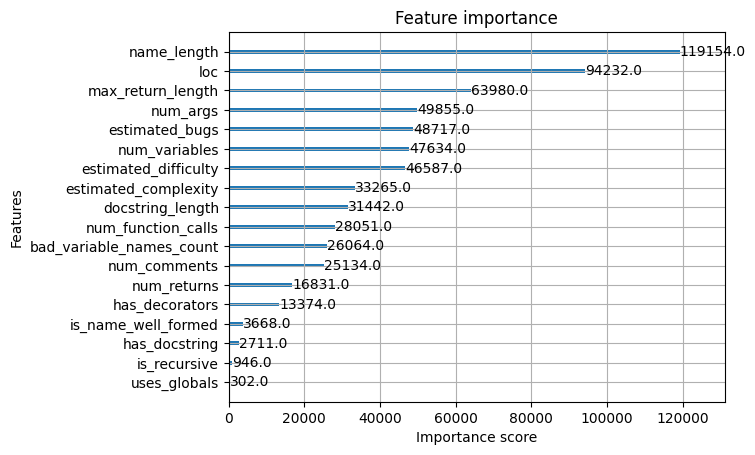

In [17]:
xgb.plot_importance(model)
plt.show()

In [ ]:
plot_learning_curve(model, X_train_scaled, y_train_encoded, cv=3, title="XGBoost Learning Curve")